In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data

Basic data cleaning includes deleting the puctuation marks in the titles, and convert text into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


In the original data, many categories are highly ralated. 59 categories are regrouped, forming larger categories. There are eventually 50 categories in total.

In [3]:
related_categories = pd.read_csv("related_categories.csv")
related_categories

,original,grouped
0,accessibility,equal_rights
1,addiction,substance_addiction
2,android-development,it_industry
3,art,cultural_topics
4,artificial-intelligence,datascience_ai
5,basic-income,political_topics
6,blockchain,finance_economy
7,business,business_marketing
8,cryptocurrency,finance_economy
9,cybersecurity,security


In [4]:
for i in related_categories.index:
    titles.category = titles.category.replace(*related_categories.loc[i])
    
titles.head()

,category,title
0,work_related,21 conversations a fun and easy game for team...
1,religion_spirituality,biblical porn at mars hill
2,equal_rights,cisgender is that a disease
3,equal_rights,call me nat love black cowboys and the frontie...
4,datascience_ai,can i train my model on your computer


Hold out 20% of data as the test set.

In [5]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

In [6]:
import warnings
warnings.filterwarnings('ignore')

The theme labels were converted to one hot representations.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

# Naive Bayess

Use TF-IDF to perform bag-of-words vectorization.

We adopted the Penn Treebank Tokenizer. Terms that appear less than twice or occur in more than 10% of the docuemnts are rejected. Typically, with TF-IDF vectorization, we can still use a multinomial naive Bayess classifier. Let's take a look at a naive Bayess classifer with Lapalace smoohing at alpha = 0.1. 

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 1), stop_words='english', min_df=2, max_df=0.1)

NBclassifier = MultinomialNB(alpha=0.1)

classifierNB = Pipeline([("TfIdf", vectorizer), ("NaiveBayess", NBclassifier)])
classifierNB.fit(X_train, y_train)

accuracyNB = classifierNB.score(X_test, y_test)
print("accuracy = {}".format(accuracyNB))

accuracy = 0.44280968201233983


# Multilayer Perceptron Network

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from keras.models import load_model

XMatrix_train = vectorizer.fit_transform(X_train)
vocabulary = np.array(vectorizer.get_feature_names())
vocabularySize = vocabulary.size

XMatrix_test = vectorizer.transform(X_test)

layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(50, activation="softmax")
classifierMLP = Sequential([layer1, layer2, outputLayer])
classifierMLP.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=50, verbose=2)
best_model_saving = ModelCheckpoint("MLP_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=2)

start_time = time()
history = classifierMLP.fit(XMatrix_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifierMLP = load_model("MLP_best_model.h5")
_, train_accuracy = classifierMLP.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifierMLP.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 101134 samples, validate on 25284 samples
Epoch 1/5000





 - 21s - loss: 3.5155 - acc: 0.1097 - val_loss: 3.0885 - val_acc: 0.2766

Epoch 00001: val_acc improved from -inf to 0.27658, saving model to MLP_best_model.h5
Epoch 2/5000
 - 21s - loss: 2.5749 - acc: 0.4056 - val_loss: 2.2730 - val_acc: 0.4344

Epoch 00002: val_acc improved from 0.27658 to 0.43442, saving model to MLP_best_model.h5
Epoch 3/5000
 - 20s - loss: 1.8542 - acc: 0.5386 - val_loss: 2.0379 - val_acc: 0.4849

Epoch 00003: val_acc improved from 0.43442 to 0.48489, saving model to MLP_best_model.h5
Epoch 4/5000
 - 20s - loss: 1.4563 - acc: 0.6265 - val_loss: 2.0181 - val_acc: 0.4900

Epoch 00004: val_acc improved from 0.48489 to 0.48995, saving model to MLP_best_model.h5
Epoch 5/5000
 - 20s - loss: 1.2116 - acc: 0.6832 - val_loss: 2.0805 - val_acc: 0.4875

Epoch 00005: val_acc did not improve from 0.48995
Epoc

 - 20s - loss: 0.1530 - acc: 0.9597 - val_loss: 4.7305 - val_acc: 0.4063

Epoch 00035: val_acc did not improve from 0.48995
Epoch 36/5000
 - 21s - loss: 0.1473 - acc: 0.9615 - val_loss: 4.7839 - val_acc: 0.4063

Epoch 00036: val_acc did not improve from 0.48995
Epoch 37/5000
 - 20s - loss: 0.1418 - acc: 0.9629 - val_loss: 4.8328 - val_acc: 0.4063

Epoch 00037: val_acc did not improve from 0.48995
Epoch 38/5000
 - 20s - loss: 0.1367 - acc: 0.9640 - val_loss: 4.8839 - val_acc: 0.4062

Epoch 00038: val_acc did not improve from 0.48995
Epoch 39/5000
 - 20s - loss: 0.1321 - acc: 0.9650 - val_loss: 4.9280 - val_acc: 0.4058

Epoch 00039: val_acc did not improve from 0.48995
Epoch 40/5000
 - 20s - loss: 0.1277 - acc: 0.9659 - val_loss: 4.9798 - val_acc: 0.4034

Epoch 00040: val_acc did not improve from 0.48995
Epoch 41/5000
 - 21s - loss: 0.1242 - acc: 0.9670 - val_loss: 5.0109 - val_acc: 0.4030

Epoch 00041: val_acc did not improve from 0.48995
Epoch 42/5000
 - 20s - loss: 0.1204 - acc: 0.968

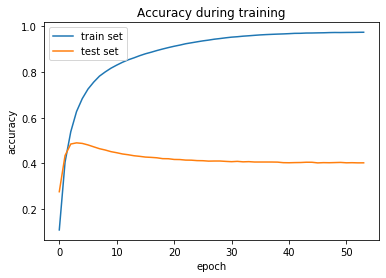

In [11]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Precision-recall

In [12]:
probabilityNB = classifierNB.predict_proba(X_test)
classListNB = classifierNB.classes_
realLabelNB = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classListNB), axis=1), np.repeat(np.reshape(classListNB, (1, -1)), len(y_test), axis=0))

probabilityMLP = classifierMLP.predict_proba(XMatrix_test)
classListMLP = integer_encoder.classes_
realLabelMLP = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classListMLP), axis=1), np.repeat(np.reshape(classListMLP, (1, -1)), len(y_test), axis=0))


thresholds = np.arange(0, 1.001, 0.001)

correctSuggestionRateNB = np.zeros(len(thresholds))
correctSuggestionRateMLP = np.zeros(len(thresholds))

for i, threshold in enumerate(thresholds):
    
    predictedLabelNB = probabilityNB >= threshold
    correctSuggestionRateNB[i] = np.any((predictedLabelNB & realLabelNB), axis=1).mean()
    
    predictedLabelMLP = probabilityMLP >= threshold
    correctSuggestionRateMLP[i] = np.any((predictedLabelMLP & realLabelMLP), axis=1).mean()

Text(0, 0.5, 'correct suggestion rate')

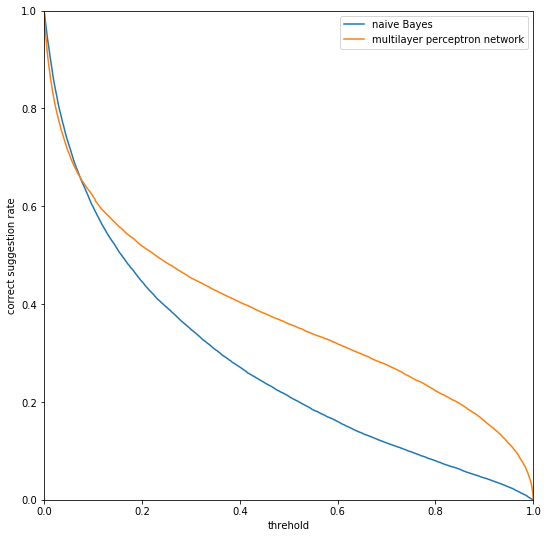

In [13]:
plt.figure(figsize=(9,9))

plt.plot(thresholds, correctSuggestionRateNB, label="naive Bayes")
plt.plot(thresholds, correctSuggestionRateMLP, label="multilayer perceptron network")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="upper right")
plt.xlabel("threhold")
plt.ylabel("correct suggestion rate")